This is an example of the complete process used to generate and plot the data for the paper 'Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates'. 

##### Requirements

In [48]:
import sinter
import stim
import numpy as np

import os
import sys

import shutil
import subprocess

sys.path.insert(0, 'functions') 
import oscAntgencircuitv2 as oscant
import morefuncs as morefuncs
import com_funcs5 as funcs

# Update with any changes to these files:
from importlib import reload
reload(morefuncs)
reload(funcs)
reload(oscant);

##### Generate surface code circuits -- choose SD or SI noise

In [49]:
# Inputs:

noise_model = 'SD' # choose SD (standard depolarising) or SI (superconducting inspired) noise
p_values = [0.002,0.003,0.004] 
ds = [2,3,5]


# (optional: choose CNOT order):
# CNOT orders for x-type and z-type stabiliser measurements        
x = (1,0,2,3) # x hook error in rotated code if last two x-type CNOT's are 12, 21, 03 or 30
z = (1,2,0,3) # z hook error in rotated code if last two z-type CNOT's are 01, 10, 23 or 32 
# x = (...) and z = (...) above define the CNOT order for x and z type stabilisers. E.g. order 10231203 avoids hook errors in the rotated code and is a worst-case CNOT order for the unrotated code if doing memory Z experiments (worst-case taken to be most applicable to all states). 
unro_CNOT_order = int(''.join(map(str, x + z)))
ro_CNOT_order = unro_CNOT_order



# Generate circuits:
reload(morefuncs)
reload(funcs)

directory = "circuits/supplementary_circuits/example_circuits"

# Delete existing example circuits so as not to sample them.
funcs.remove_files_within_directories(directory)


for ro in ['unro','ro']:  
    for d in ds:
        for p in p_values:
            for b in 'xz':
                thecircuit = oscant.generate_circuit(
                    f"surface_code:{ro}tated_memory_{b}",
                    rounds=3*d, 
                    distance=d, 
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=p,
                    before_measure_flip_probability=p, 
                    # before_round_data_depolarization=p, # this is removed as we will be adding idling errors anyway which do the same thing
                    x_cnot_order = x,
                    z_cnot_order = z,
                    exclude_other_basis_detectors = True, # no need to add their detections to the graph which will be given to PyMatching as it is not a correlated decoder (circuit still performs the opposite basis' stabiliser measurements though, just doesn't include their results in the detector matching graph)
                )

                morefuncs.add_idling_errors_and_save_circuit(thecircuit, b, d, p, ro, x, z,directory) # saves circuit in circuits/SD (standard depolarising)
                # # Generate SI (SI with CX gates) p_values model circuits too by adjusting error probabilities of SD circuits then saving a separate circuit:
                if noise_model == 'SI':
                    thecircuit = morefuncs.make_SI_circuit(b, d, p, ro, x, z, directory)
if noise_model == 'SI':
    funcs.remove_files_within_directories(f"{directory}/SD")

##### Optional: visualise a circuit

Visualise one of the circuits generated above (includes idling errors):

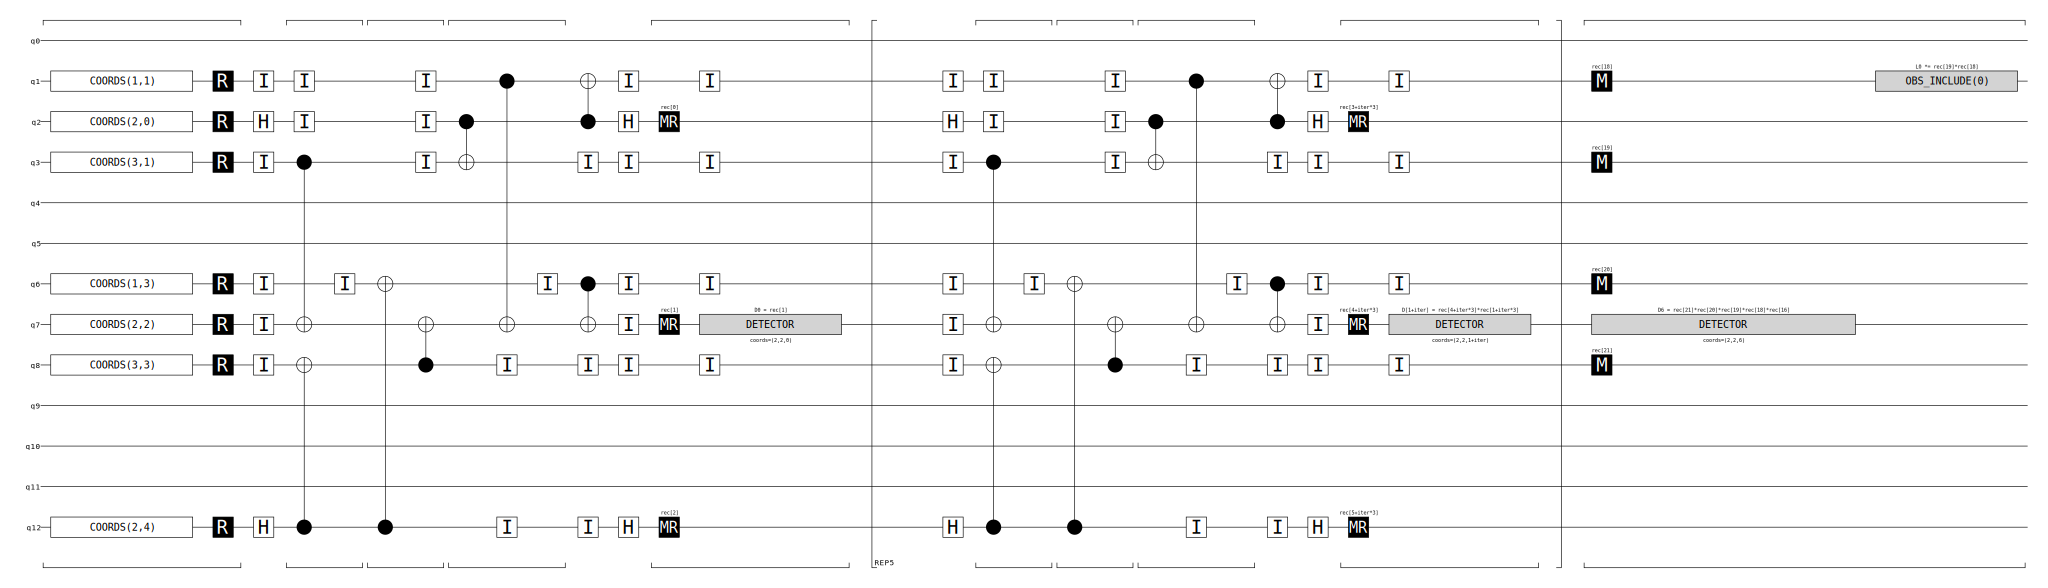

In [50]:
noise_model = 'SD'
d = ds[0] # distance 
p = p_values[1] # physical error rate
basis = 'z' # choices are x (preserve logical plus state) or z (preserve logical zero state)
rot = 'ro' # choices are 'ro' or 'unro' for rotated or unrotated surface code
order = unro_CNOT_order # CNOT order as an integer.

circuit_path = f"{directory}/{noise_model}/{basis}/d={d},p={p},noise={noise_model},b={basis},r=3d,ro={rot},o={order},idl=y.stim"
thecircuit = stim.Circuit.from_file(circuit_path) 

# print(repr(thecircuit))
# display(thecircuit.diagram('timeline-svg'))
display(thecircuit.without_noise().diagram('timeline-svg'))
# display(thecircuit.diagram("matchgraph-3d") ) # the matching graph given to pymatching. 

# display(thecircuit.without_noise().diagram("detslice-with-ops-svg", tick=range(0,4))) # note only one stab. type detecting region appears if exlude_other_basis_detectors above is True, though the operations will still be done to measure that stabiliser
# display(thecircuit.without_noise().diagram("detslice-svg", tick=range(0,4)))
# display(thecircuit.diagram('timeline-svg', tick = range(0,4)))

##### Sample the circuits:

In [51]:
%%bash

rm collected_stats/example_stats.csv 2>/dev/null

sinter collect \
    --processes 4 \
    --circuits circuits/supplementary_circuits/example_circuits/*/*/*.stim \
    --metadata_func "sinter.comma_separated_key_values(path)" \
    --decoders pymatching \
    --max_shots 10_000 \
    --max_errors 10_000 \
    --save_resume_filepath collected_stats/example_stats.csv

Starting 4 workers...
36 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.002,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.003,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.003,r=3d,ro=unro}
36 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=10000    errors_left=10000   {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.002,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=2,idl=y,noise=SD,o=10231203,p=0.003,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=N

In [52]:
# # (optional) combine and print the stats,:
# mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# for el in mylist: 
#     print(el)

##### Threshold plots: $p_L$ vs. $p$

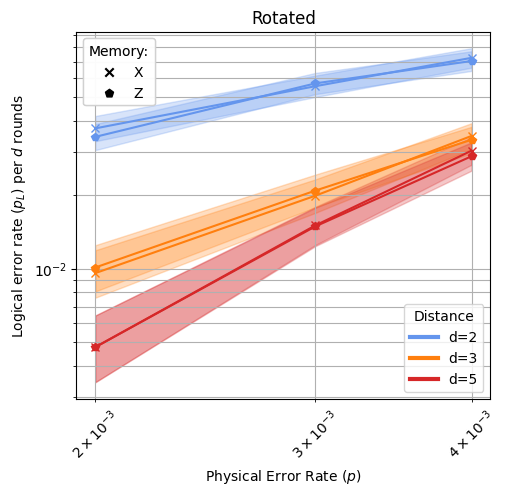

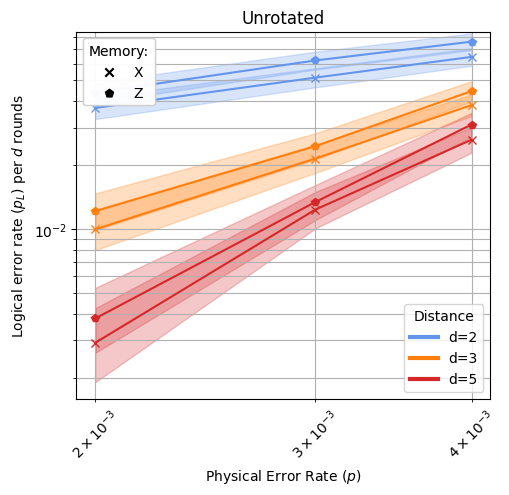

In [53]:
reload(funcs)
mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
funcs.plot_thresholds(mylist, ro_CNOT_order, unro_CNOT_order) # expects data for both rotated and unrotated code

##### Fit to scaling function $p_L = \alpha ( p / \beta)^{\gamma d - \delta}$

(Note, can get errors in this scaling function if don't have enough data. 3 distances at 3 error rates is usually good)


ro z 10231203

    α = 0.118 ± 0.067
    β = 0.00775 ± 0.00040
    γ = 0.508 ± 0.094
    δ = -0.10 ± 0.33


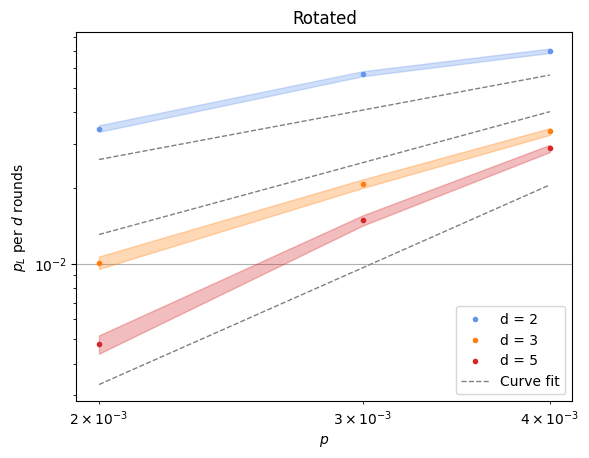


unro z 10231203

    α = 0.107 ± 0.043
    β = 0.00618 ± 0.00011
    γ = 0.722 ± 0.130
    δ = 0.50 ± 0.46


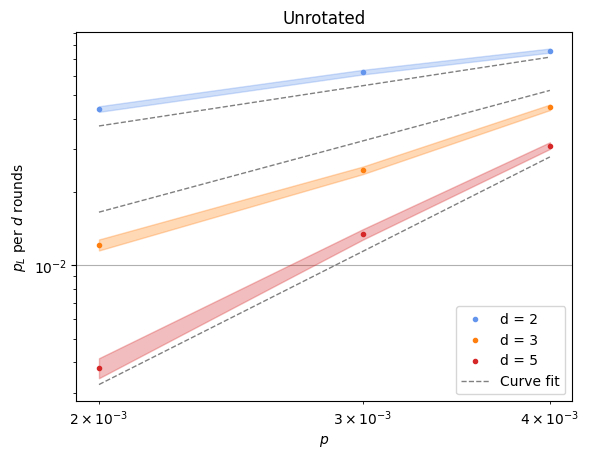

In [54]:
reload(funcs)
distances = 'combined' # choices are 'odd', 'even' or 'combined'
b = 'z' # choices are x or z 
noise_model = 'SD' # choices are SD or SI

funcs.fit_scaling_and_plot(mylist, distances, b, ro_CNOT_order, unro_CNOT_order, minp = min(p_values), maxp = max(p_values)) 

##### Plot as $p_L$ vs. $\sqrt{n}$

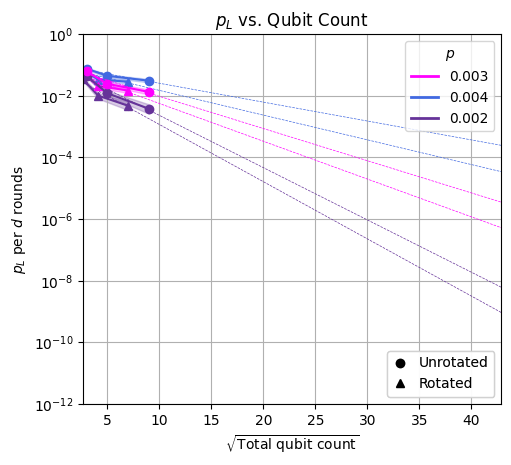

In [55]:
reload(funcs)

b = 'z' 

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# 
funcs.plot_pL_vs_qubit_count(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Plot 'teraquop' count :$\ $ the number of qubits required to reach $p_L = 10^{-12}$

<IPython.core.display.Math object>

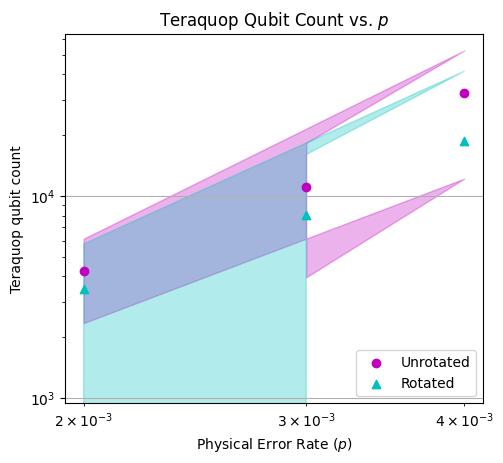

In [56]:
reload(funcs)
funcs.plot_teraquop(mylist, b, ro_CNOT_order, unro_CNOT_order, optional_plot = False)

##### Plot ratios of qubit counts vs. $p_L$

This is the projected number of qubits used by the rotated surface code divided by the number of qubits used by the unrotated surface code to achieve the same $p_L$

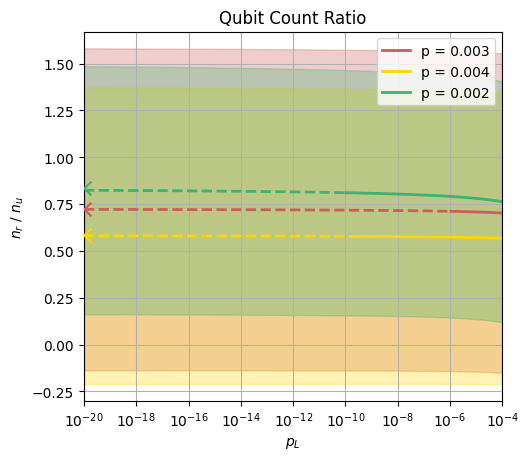

In [57]:
reload(funcs)

funcs.plot_ratio(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Memory time vs. $\sqrt{n}$

This is a reformulation of the $p_L$ vs. $\sqrt{n}$ plots above, converting the $p_L$ per $d$ rounds to be the length of time (assuming one stabiliser measurement cycle take a microsecond) before $p_L$ over the entire shot of the memory experiment equals $p$.

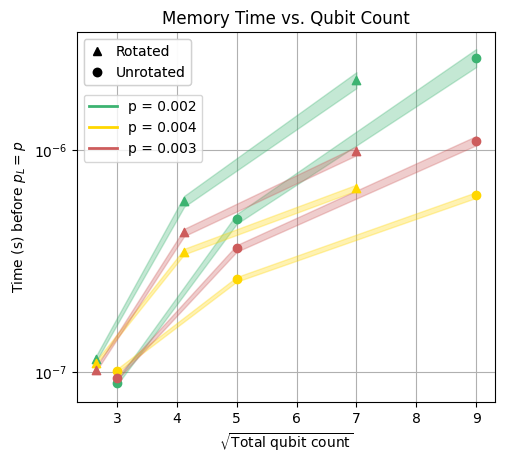

In [58]:
funcs.plot_memory_times(mylist, b, ro_CNOT_order, unro_CNOT_order)